## Libraries

In [12]:
import numpy as np
import pandas as pd
from typing import Sequence, Optional, Tuple
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, iirnotch, decimate, detrend, filtfilt

In [8]:
paths = {
    "normal": "Test_In_Home_1.csv",
    "desbalanceado": "Test_In_Home_2.csv"
}

fs_acc = 1920
fs_gyro = 1920
fs_mag = 50

## Helpers

In [2]:

# ---------- Core Helpers ----------
def compute_fs(t_ms):
    t = np.asarray(t_ms, float) / 1000.0
    dt = np.diff(t)
    dt = dt[(dt>0) & np.isfinite(dt)]
    return 1.0 / np.median(dt)

def _validate_fs_fc(fc_hz: float, fs: float) -> float:
    """
    Ensures the cutoff is strictly below Nyquist and positive.
    Clips to 0.45*fs if needed to keep a safe distance from Nyquist.
    """
    if fs <= 0:
        raise ValueError("Sampling rate fs must be > 0.")
    if fc_hz <= 0:
        raise ValueError("Cutoff frequency must be > 0.")
    nyq = fs * 0.5
    if fc_hz >= nyq:
        # Clip + warn by comment; caller can log if desired
        fc_hz = 0.45 * fs  # safe guard near Nyquist
    return fc_hz

def butter_lowpass_sos(fc_hz: float, fs: float, order: int = 4):
    """
    Designs a Butterworth low-pass filter in SOS form (numerically stable).
    fc_hz: cutoff frequency in Hz (3 dB).
    """
    fc_hz = _validate_fs_fc(fc_hz, fs)
    Wn = fc_hz / (fs * 0.5)
    sos = butter(order, Wn, btype="low", output="sos")
    return sos

def butter_highpass_sos(fc_hz: float, fs: float, order: int = 4):
    """
    Butterworth high-pass (SOS).
    Useful e.g. to remove very low drift when you don't want to detrend.
    """
    if fs <= 0:
        raise ValueError("Sampling rate fs must be > 0.")
    if fc_hz <= 0:
        raise ValueError("Cutoff frequency must be > 0.")
    Wn = fc_hz / (fs * 0.5)
    if Wn >= 1.0:
        raise ValueError("High-pass cutoff must be below Nyquist.")
    sos = butter(order, Wn, btype="high", output="sos")
    return sos

def butter_bandpass_sos(f_lo: float, f_hi: float, fs: float, order: int = 4):
    """
    Butterworth band-pass (SOS). Order applies to the whole BP section
    (internally split across low/high).
    """
    if not (0 < f_lo < f_hi):
        raise ValueError("Require 0 < f_lo < f_hi.")
    nyq = fs * 0.5
    if f_hi >= nyq:
        f_hi = 0.45 * fs
    Wn = (f_lo/nyq, f_hi/nyq)
    sos = butter(order, Wn, btype="bandpass", output="sos")
    return sos

def apply_sos_zero_phase(x: np.ndarray, sos, axis: int = 0) -> np.ndarray:
    """
    Zero-phase filtering (forward+backward) using SOS sections.
    Preserves shape of x and applies along the chosen axis.
    """
    return sosfiltfilt(sos, x, axis=axis)

# ---------- Notch (single and comb) ----------

def design_notch_tf(f0_hz: float, fs: float, Q: float = 30.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Designs an IIR notch (biquad) at f0 with quality factor Q.
    Returns (b, a) transfer function coefficients.
    """
    if fs <= 0: 
        raise ValueError("fs must be > 0.")
    if not (0 < f0_hz < fs*0.5):
        raise ValueError("f0 must be between (0, Nyquist).")
    w0 = f0_hz / (fs*0.5)
    b, a = iirnotch(w0=w0, Q=Q)
    return b, a

def apply_notch(x: np.ndarray, f0_hz: float, fs: float, Q: float = 30.0, axis: int = 0) -> np.ndarray:
    """
    Zero-phase notch at f0. Uses filtfilt on (b,a).
    """
    b, a = design_notch_tf(f0_hz, fs, Q)
    return filtfilt(b, a, x, axis=axis)

def apply_comb_notch(x: np.ndarray, fs: float, f0_list: Sequence[float], Q: float = 30.0, axis: int = 0) -> np.ndarray:
    """
    Applies multiple narrow notches (e.g., 50 Hz and harmonics: 50, 100, 150...).
    Automatically skips frequencies >= Nyquist.
    """
    y = x
    nyq = fs * 0.5
    for f0 in f0_list:
        if 0 < f0 < nyq:
            b, a = design_notch_tf(f0, fs, Q)
            y = filtfilt(b, a, y, axis=axis)
    return y

# ---------- Convenience wrappers ----------

def apply_lowpass(x: np.ndarray, fc_hz: float, fs: float, order: int = 4, axis: int = 0) -> np.ndarray:
    """
    Low-pass with SOS + zero-phase.
    """
    sos = butter_lowpass_sos(fc_hz, fs, order)
    return apply_sos_zero_phase(x, sos, axis=axis)

def apply_highpass(x: np.ndarray, fc_hz: float, fs: float, order: int = 4, axis: int = 0) -> np.ndarray:
    sos = butter_highpass_sos(fc_hz, fs, order)
    return apply_sos_zero_phase(x, sos, axis=axis)

def apply_bandpass(x: np.ndarray, f_lo: float, f_hi: float, fs: float, order: int = 4, axis: int = 0) -> np.ndarray:
    sos = butter_bandpass_sos(f_lo, f_hi, fs, order)
    return apply_sos_zero_phase(x, sos, axis=axis)


## Load Data

In [ ]:
sessions = []   # items: {label, df, A, G, M, fs}

base_dir = Path("./Dados/Trabalhado")

for label, name in paths.items():
    fpath = base_dir / name
    if not fpath.exists():
        raise FileNotFoundError(f"File not found: {fpath.resolve()}")
    df = pd.read_csv(fpath)
    
    # estimate sampling frequency from Timestamp (ms) — uses compute_fs
    fs = compute_fs(df["Timestamp"])
    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"Invalid sampling freq for {name}: {fs}")
    
    # convert to numeric arrays and handle NaNs later if needed
    A = df[["Accel_X", "Accel_Y", "Accel_Z"]].to_numpy(dtype=float)
    G = df[["Gyro_X",  "Gyro_Y",  "Gyro_Z"]].to_numpy(dtype=float)
    M = df[["Mag_X",   "Mag_Y",   "Mag_Z"]].to_numpy(dtype=float)
    
    sessions.append({
        "label": label,
        "df": df,
        "A": A,
        "G": G,
        "M": M,
        "fs": fs,
    })


In [32]:
# print(f"Processed files: {sessions}")
#print(f"Fs: {[s['fs'] for s in sessions]} Hz")

# Print the session with label "normal"
normal_session = next(s for s in sessions if s['label'] == "normal")
print(normal_session)

{'label': 'normal', 'df':       Timestamp  Accel_X  Accel_Y  Accel_Z  Gyro_X  Gyro_Y  Gyro_Z  Mag_X  \
0             0        9       50      996       0       0       0    -27   
1            10       40       47     1018       0       0       0    -27   
2            20       22       48      997       0       0       0    -27   
3            30       30       42     1010      -1       0       0    -25   
4            40       28       44     1001      -1       0       0    -27   
...         ...      ...      ...      ...     ...     ...     ...    ...   
3495      34950      602     -230     1231      -3      -1     243   -150   
3496      34960      -51       11      928      -1      17     245   -141   
3497      34970     -167      333      958       3      -2     232   -135   
3498      34980       -3      221     1103      -2       1     222   -124   
3499      34990      636     -735      752       0      -8     230   -121   

      Mag_Y  Mag_Z  
0       118   -891  
1      

## Work Data

### Pre processing data

In [ ]:
# 1) Detrend to remove DC/drift (acc/gyro). For mag, keep raw for calibration stage

A_detrend = detrend(A, axis=0, type="linear")
G_detrend = detrend(G, axis=0, type="linear")

# 2) Low-pass (A/G @ 1920 Hz) -> 200 Hz cutoff
A_lp = apply_lowpass(A_detrend, fc_hz=200.0, fs=fs_acc, order=4, axis=0)
G_lp = apply_lowpass(G_detrend, fc_hz=200.0, fs=fs_gyro, order=4, axis=0)

# 3) Notch if mains present (optional)
# A_lp = apply_notch(A_lp, f0_hz=50.0, fs=fs_acc, Q=30.0, axis=0)
# G_lp = apply_notch(G_lp, f0_hz=50.0, fs=fs_gyro, Q=30.0, axis=0)

# 4) Downsample A/G to 400 Hz (factor 1920/400 = 4.8 -> use 5x with prior LPF ~200 Hz)
#    Prefer integer factor; with LPF=200 Hz and new Nyquist=200 Hz (400 Hz fs), we are on the limit.
#    If quiser mais margem, use new_fs=320 Hz (factor=6) e LPF=150 Hz.
factor = 5
A_ds = decimate(A_lp, factor, ftype='fir', axis=0)
G_ds = decimate(G_lp, factor, ftype='fir', axis=0)
fs_ds = fs_acc / factor  # ~384 Hz (se 1920/5)

# 5) Z-score per session (USE TRAIN STATS ONLY in production)
A_mu, A_sd = A_ds.mean(axis=0), A_ds.std(axis=0, ddof=1); A_sd[A_sd==0]=1.0
G_mu, G_sd = G_ds.mean(axis=0), G_ds.std(axis=0, ddof=1); G_sd[G_sd==0]=1.0
A_std = (A_ds - A_mu)/A_sd
G_std = (G_ds - G_mu)/G_sd

# 6) Magnetometer calibration (hard/soft-iron)
#    -> Faça uma sessão de calibração e salve center, S. Aqui, aplicamos:
# M_cal = (M - center) @ S.T
M_cal = M.copy()  # placeholder: aplique sua calibração real aqui

# 7) Magnetometer low-pass (ODR 50 or 100 Hz)
fc_mag = 20.0 if fs_mag<=50.0 else 40.0
M_lp = apply_lowpass(M_cal, fc_hz=fc_mag, fs=fs_mag, order=4, axis=0)

# 8) Remove DC (for spectral analysis)
M_dc = M_lp - M_lp.mean(axis=0, keepdims=True)

# 9) Tilt compensation -> heading(t)
#    First low-pass accel (very low cutoff) on the *downsampled* accel to estimate gravity
from math import atan2
A_grav = apply_lowpass(A_std, fc_hz=5.0, fs=fs_ds, order=2, axis=0)
ax, ay, az = A_grav[:,0], A_grav[:,1], A_grav[:,2]
roll  = np.arctan2( ay, np.sqrt(ax*ax + az*az) )
pitch = np.arctan2(-ax, np.sqrt(ay*ay + az*az) )

# apply tilt compensation on magnetometer (interpolate M to A timebase if necessário)
# aqui suponho que você calcula features por janela, então não precisa retimar amostra a amostra.
def tilt_comp(Mx, My, Mz, roll, pitch):
    sr, cr = np.sin(roll),  np.cos(roll)
    sp, cp = np.sin(pitch), np.cos(pitch)
    v1x = Mx
    v1y = cr*My + sr*Mz
    v1z = -sr*My + cr*Mz
    v2x =  cp*v1x + sp*v1z
    v2y =  v1y
    v2z = -sp*v1x + cp*v1z
    return v2x, v2y, v2z

# (Se quiser heading em tempo contínuo, reamostre M para fs_ds e aplique tilt_comp ponto a ponto.)

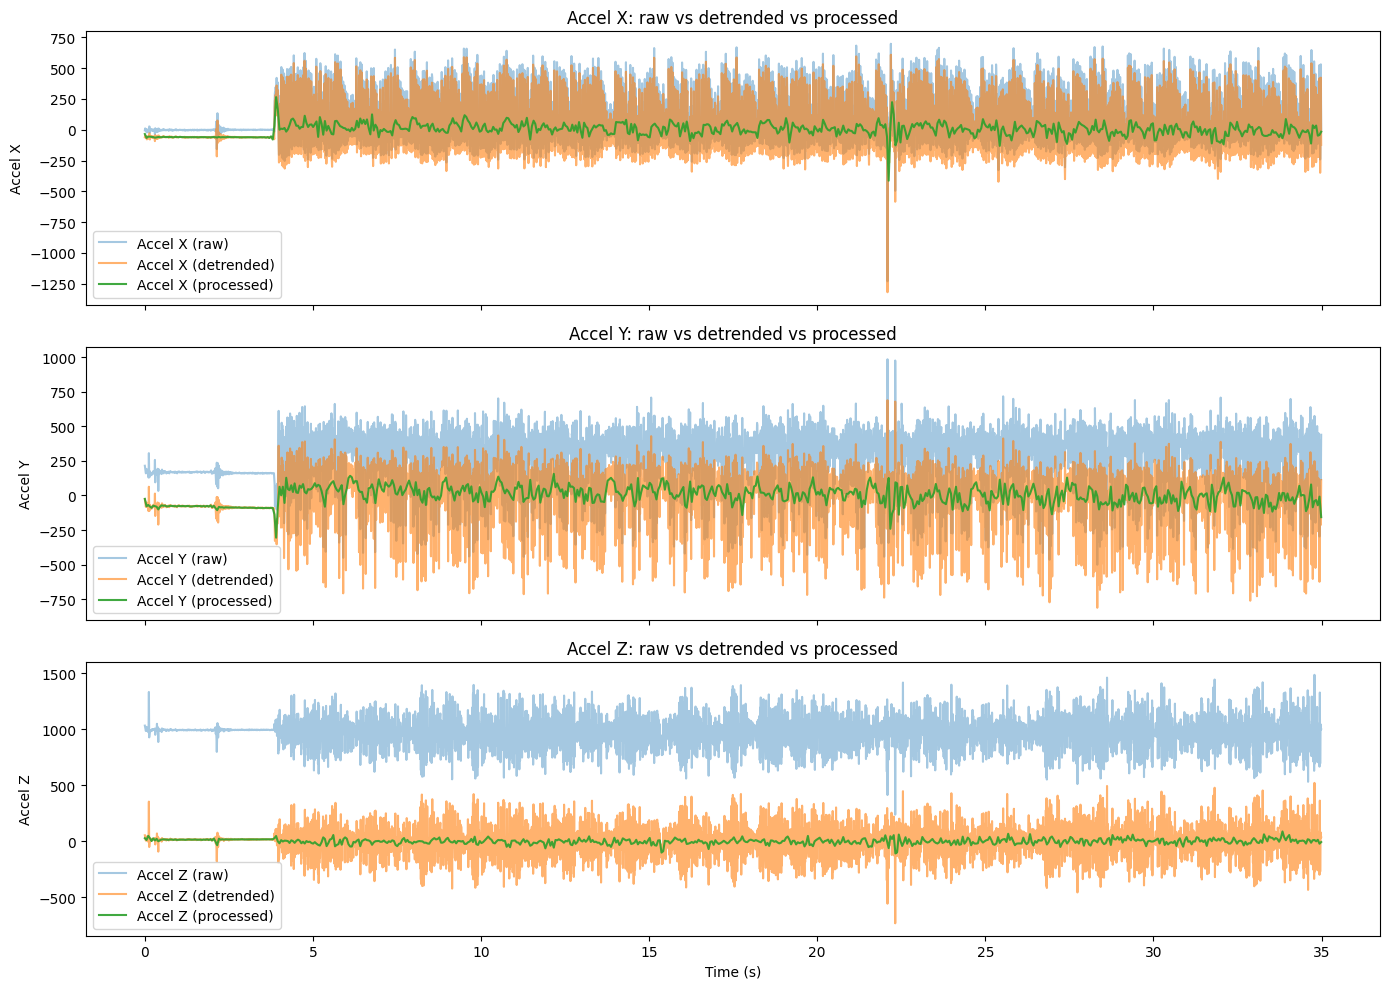

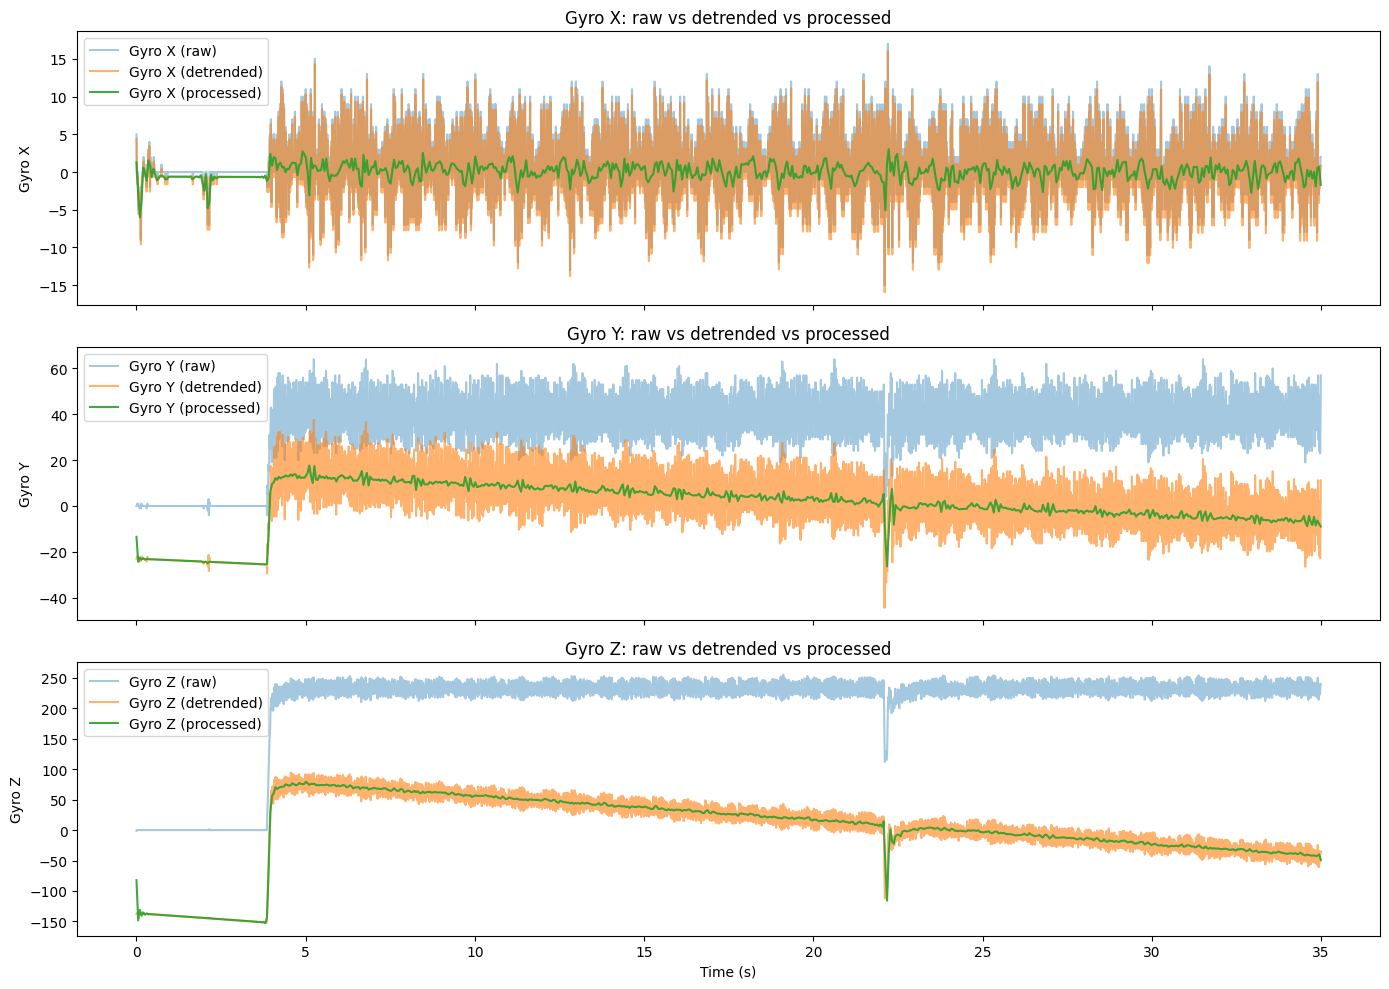

In [16]:
#quero plotar o grafico para os 3 eixos

# Define t_raw (raw time in seconds) and t_ds (downsampled time in seconds)
t_raw = df["Timestamp"].values / 1000.0
t_ds = np.linspace(t_raw[0], t_raw[-1], A_ds.shape[0])

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

eixos = ['X', 'Y', 'Z']
for i in range(3):
    axs[i].plot(t_raw, A[:,i], alpha=0.4, label=f"Accel {eixos[i]} (raw)")
    axs[i].plot(t_raw, A_detrend[:,i], alpha=0.6, label=f"Accel {eixos[i]} (detrended)")
    axs[i].plot(t_ds,  A_ds[:,i], alpha=0.9, label=f"Accel {eixos[i]} (processed)")
    axs[i].legend()
    axs[i].set_ylabel(f"Accel {eixos[i]}")
    axs[i].set_title(f"Accel {eixos[i]}: raw vs detrended vs processed")
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
for i in range(3):
    axs[i].plot(t_raw, G[:,i], alpha=0.4, label=f"Gyro {eixos[i]} (raw)")
    axs[i].plot(t_raw, G_detrend[:,i], alpha=0.6, label=f"Gyro {eixos[i]} (detrended)")
    axs[i].plot(t_ds,  G_ds[:,i], alpha=0.9, label=f"Gyro {eixos[i]} (processed)")
    axs[i].legend()
    axs[i].set_ylabel(f"Gyro {eixos[i]}")
    axs[i].set_title(f"Gyro {eixos[i]}: raw vs detrended vs processed")
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()
# --- Plot results ---



### Pr